# Lotka-Volterra inference tests

In [9]:
import numpy as np
import corner
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import mean_squared_error
import collections

from goldmine.inference.nde import MAFInference
from goldmine.simulators.lotka_volterra import LotkaVolterra

## Methods and sample sizes

In [10]:
sample_sizes = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

methods = ['carl', 'maf', #'rolr',
           'rascal', 'cascal', 'scandal', 'scandal', 'rascandal']
model_labels = ['', '_mog', #'',
                '', '', '_mog_largealpha', '_mog']
legend_labels = [r'LRT, ROLR$\,$', r'MAF$\,$', #'ROLR',
                 r'RASCAL, $\alpha$=0.01', r'CASCAL, $\alpha$=0.01', '', r'SCANDAL, $\alpha$=0.01 (dashed: 0.1)']

linestyles = ['-', '-', #'-',
             '-', '-', '--', '-']
colors      = ['darkgreen', 'C1',#'c',
               '#CC002E','#be96ff','#0064b4','#0064b4']
band_alphas = [0.15 for _ in colors]


## Plotting tools

In [11]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_r_absolute_extra = 8. * 0.1
margin_sep_absolute = 8. * 0.02
margin_sep_small_absolute = 8. * 0.01
margin_t_absolute = 8. * 0.02
margin_t_absolute_extra = 8. * 0.12
margin_b_absolute = 8. * 0.08


def custom_figure(
    n_panels=2,
    width=8.,
    panel_aspect_ratio=1.,
    extra_top_space=False,
    reduce_vertical_sep=False,
):

    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1

    # Determine top margin
    _margin_t_absolute = (
        margin_t_absolute_extra if extra_top_space else margin_t_absolute
    )

    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (
        1. - margin_l - margin_r - (n_panels_h - 1) * margin_sep_total
    ) / n_panels_h

    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width

    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = (
        n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute)
        + (n_panels_v - 1) * margin_sep_absolute
    )

    # Calculate vertical margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    if reduce_vertical_sep:
        margin_sep_total = margin_sep_small_absolute / height
    else:
        margin_sep_total = margin_t + margin_b + margin_sep_absolute / height

    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height

    # New figure
    fig = plt.figure(figsize=(width, height))

    # Adjust margins
    plt.subplots_adjust(
        left=margin_l,
        right=1. - margin_r,
        bottom=margin_b,
        top=1. - margin_t,
        wspace=wspace,
        hspace=hspace,
    )

    return fig

In [12]:
def calculate_height(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False, extra_r_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    _margin_r_absolute = margin_r_absolute_extra if extra_r_space else margin_r_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = _margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False, extra_r_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    _margin_r_absolute = margin_r_absolute_extra if extra_r_space else margin_r_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = _margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace,
                        hspace = hspace)
    

## Calculate metrics on grid

In [13]:
def load_metrics_grid(simulator='lotkavolterra',
                      method='maf',
                      label='',
                      reference_method='rascandal',
                      reference_label='',
                      quantity='log_p_hat',
                      n_runs=10,
                      reference_n_runs=10,
                      expectation_index=312):
    
    reference_path = '../../data/results/' + simulator + '/' + reference_method + '/'
    path = '../../data/results/' + simulator + '/' + method + '/'
    sample_label = 'test_zoom_singletheta_evaluated_on_grid_'
    
    # Reference likelihood
    log_p_references = []
    t_references = []
    for run in range(reference_n_runs):
        run_label = '' if run == 0 else '_run' +  str(run)
        try:
            log_p_reference = np.load(reference_path + quantity + '_' + sample_label + reference_label + run_label + '.npy')
            log_p_references.append(
                log_p_reference
            )
        except FileNotFoundError as e:
            print(e)
            pass
    log_p_references = np.array(log_p_references)
    log_p_reference = np.median(log_p_references, axis=0)
    
    # Calculate metrics
    mses = []
    
    for run in range(n_runs):
        run_label = '' if run == 0 else '_run' +  str(run)
        try:
            log_p = np.load(
                path + quantity + '_' + sample_label + label + run_label + '.npy'
            )
            log_p = log_p
            
            n_infs = np.sum(~np.isfinite(log_p))
            if n_infs > 0:
                print('{} infs for {}'.format(n_infs, method))
                log_p[~np.isfinite(log_p)] = -100.
            
            mses.append(
                mean_squared_error(log_p_reference.flatten(), log_p.flatten())
            )
        
        except FileNotFoundError as e:
            #print(e)
            pass
        
    mses = np.array(mses)
        
    # Calculate mean and std
    mse_mean = np.median(mses)
    mse_uncertainty = np.std(mses) / len(mses)**0.5
    
    return (mse_mean, mse_uncertainty)


In [19]:
metrics = []

for method, model_label in zip(methods, model_labels):
    metrics_this_method = []
    
    for sample_size in sample_sizes:
        
        samplesize_label = '_trainingsamplesize_' + str(sample_size)
            
        metrics_this_method.append(
            load_metrics_grid(
                method=method,
                label='_model_zoom' + model_label + samplesize_label,
                reference_method='maf',
                reference_label='_model_zoom_mog_trainingsamplesize_200000',
                quantity='log_p_hat'
            )
        )
        
    metrics.append(metrics_this_method)
    
metrics = np.array(metrics)

log_p_grid_mse_mean = metrics[:,:,0]
log_p_grid_mse_uncertainties = metrics[:,:,1]


/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
metrics = []

for method, model_label in zip(methods, model_labels):
    metrics_this_method = []
    
    for sample_size in sample_sizes:
        
        samplesize_label = '_trainingsamplesize_' + str(sample_size)
            
        metrics_this_method.append(
            load_metrics_grid(
                method=method,
                label='_model_zoom' + model_label + samplesize_label,
                reference_method='scandal',
                reference_label='_model_zoom_mog_largealpha_trainingsamplesize_200000',
                quantity='log_r_hat'
            )
        )
        
    metrics.append(metrics_this_method)
    
metrics = np.array(metrics)

log_r_grid_mse_mean = metrics[:,:,0]
log_r_grid_mse_uncertainties = metrics[:,:,1]


## Plots

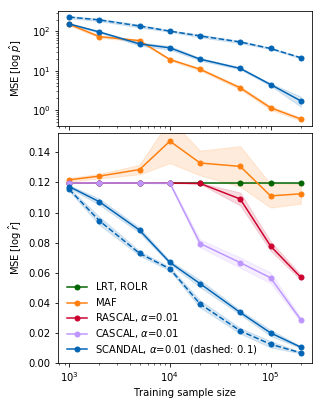

In [23]:
fig = custom_figure((1, 2), 4.5, 1.8, reduce_vertical_sep=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[0.3,0.6])



ax = plt.subplot(gs[1])

for m, method in enumerate(legend_labels):
    plt.fill_between(
        sample_sizes,
        log_r_grid_mse_mean[m] - log_r_grid_mse_uncertainties[m],
        log_r_grid_mse_mean[m] + log_r_grid_mse_uncertainties[m],
        color=colors[m],
        alpha=band_alphas[m]
    )
    
for m, method in enumerate(legend_labels):
    plt.plot(
        sample_sizes,
        log_r_grid_mse_mean[m],
        color=colors[m],
        lw=1.5,
        ls=linestyles[m],
        marker='o',
        ms=5.,
        label=None if method == '' else method
    )
    
plt.legend(loc='lower left', edgecolor='white', facecolor='white', framealpha=0.,
           bbox_to_anchor=(0.,-0.01), labelspacing=0.3)

plt.xlabel('Training sample size')
ax.set_xscale("log", nonposx='clip')
plt.ylabel(r'$\mathrm{MSE} \; [ \log \; \hat{r} ] $')
plt.ylim(0.,0.153)
ax.yaxis.set_label_coords(-0.13, 0.5)



ax2 = plt.subplot(gs[0], sharex=ax)

for m, method in enumerate(legend_labels):
    if np.any(np.isfinite(log_p_grid_mse_mean[m])):
        plt.fill_between(
            sample_sizes,
            log_p_grid_mse_mean[m] - log_p_grid_mse_uncertainties[m],
            log_p_grid_mse_mean[m] + log_p_grid_mse_uncertainties[m],
            color=colors[m],
            alpha=band_alphas[m]
        )
    
for m, method in enumerate(legend_labels):
    if np.any(np.isfinite(log_p_grid_mse_mean[m])):
        plt.plot(
            sample_sizes,
            log_p_grid_mse_mean[m],
            color=colors[m],
            lw=1.5,
            ls=linestyles[m],
            marker='o',
            ms=5.,
            label=None if method == '' else method
        )

plt.ylabel(r'$\mathrm{MSE} \; [ \log \; \hat{p} ] $')
ax2.set_yscale("log", nonposy='clip')
#plt.ylim(0.,200.)
#ax2.xaxis.set_ticks_position("none")
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.yaxis.set_label_coords(-0.13, 0.5)



plt.savefig("lotka_volterra_results.pdf")


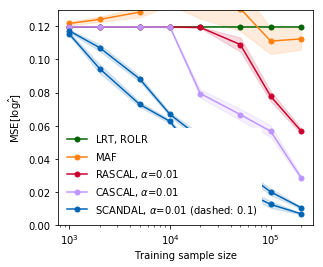

In [24]:
fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,1,False)))
ax = plt.gca()

for m, method in enumerate(legend_labels):
    plt.fill_between(
        sample_sizes,
        log_r_grid_mse_mean[m] - log_r_grid_mse_uncertainties[m],
        log_r_grid_mse_mean[m] + log_r_grid_mse_uncertainties[m],
        color=colors[m],
        alpha=band_alphas[m]
    )
    
for m, method in enumerate(legend_labels):
    plt.plot(
        sample_sizes,
        log_r_grid_mse_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=None if method == '' else method
    )
    
plt.legend(loc='lower left', edgecolor='white', facecolor='white', framealpha=1.)

plt.xlabel('Training sample size')
plt.ylabel(r'$\mathrm{MSE} [ \log \hat{r} ] $')
ax.set_xscale("log", nonposx='clip')
plt.ylim(0.,0.13)

adjust_margins(1,4.5,1,True)
# plt.savefig('lotka_volterra_mse_vs_samplesize.pdf')


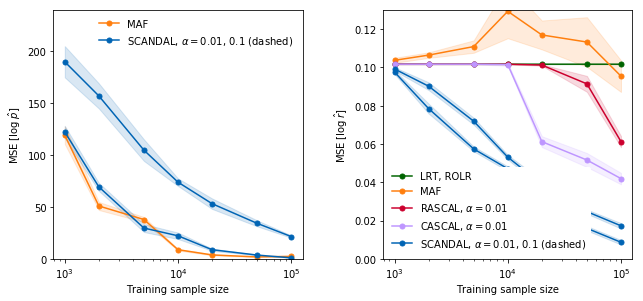

In [10]:
fig = plt.figure(figsize=(9.,calculate_height(2,9.,1,False)))


ax = plt.subplot(1,2,1)

for m, method in enumerate(legend_labels):
    if np.any(np.isfinite(log_p_grid_mse_mean[m])):
        plt.fill_between(
            sample_sizes,
            log_p_grid_mse_mean[m] - log_p_grid_mse_uncertainties[m],
            log_p_grid_mse_mean[m] + log_p_grid_mse_uncertainties[m],
            color=colors[m],
            alpha=band_alphas[m]
        )
    
for m, method in enumerate(legend_labels):
    if np.any(np.isfinite(log_p_grid_mse_mean[m])):
        plt.plot(
            sample_sizes,
            log_p_grid_mse_mean[m],
            color=colors[m],
            lw=1.5,
            ls='-',
            marker='o',
            ms=5.,
            label=method
        )
    
plt.legend(loc='upper right', edgecolor='white', facecolor='white', framealpha=1.)

plt.xlabel('Training sample size')
plt.ylabel(r'$\mathrm{MSE} \; [ \log \; \hat{p} ] $')
ax.set_xscale("log", nonposx='clip')
plt.ylim(0.,240.)


ax = plt.subplot(1,2,2)

for m, method in enumerate(legend_labels):
    plt.fill_between(
        sample_sizes,
        log_r_grid_mse_mean[m] - log_r_grid_mse_uncertainties[m],
        log_r_grid_mse_mean[m] + log_r_grid_mse_uncertainties[m],
        color=colors[m],
        alpha=band_alphas[m]
    )
    
for m, method in enumerate(legend_labels):
    plt.plot(
        sample_sizes,
        log_r_grid_mse_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend(loc='lower left', edgecolor='white', facecolor='white', framealpha=1.)

plt.xlabel('Training sample size')
plt.ylabel(r'$\mathrm{MSE} \; [ \log \; \hat{r} ] $')
ax.set_xscale("log", nonposx='clip')
plt.ylim(0.,0.13)
    

adjust_margins(2,9.,1,False)
# plt.savefig('lotka_volterra_mses_vs_samplesize.pdf')


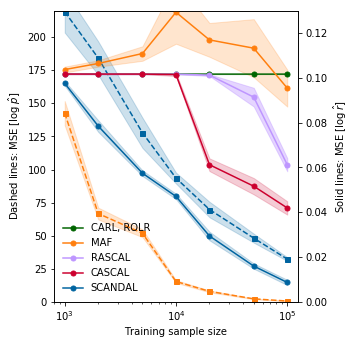

In [225]:
fig = plt.figure(figsize=(5.,calculate_height(1,5.,1.0,True, True)))


ax = plt.gca()

for m, method in enumerate(legend_labels):
    if np.any(np.isfinite(log_p_grid_mse_mean[m])):
        plt.fill_between(
            sample_sizes,
            log_p_grid_mse_mean[m] - log_p_grid_mse_uncertainties[m],
            log_p_grid_mse_mean[m] + log_p_grid_mse_uncertainties[m],
            color=colors[m],
            alpha=band_alphas[m]
        )
    
for m, method in enumerate(legend_labels):
    if np.any(np.isfinite(log_p_grid_mse_mean[m])):
        plt.plot(
            sample_sizes,
            log_p_grid_mse_mean[m],
            color=colors[m],
            lw=1.5,
            ls='--',
            marker='s',
            ms=5.,
            label=method
        )

plt.xlabel('Training sample size')
plt.ylabel(r'Dashed lines: $\mathrm{MSE} \; [ \log \; \hat{p} ] $')
ax.set_xscale("log", nonposx='clip')
plt.ylim(0.,220.)



ax2 = plt.twinx(ax)

for m, method in enumerate(legend_labels):
    plt.fill_between(
        sample_sizes,
        log_r_grid_mse_mean[m] - log_r_grid_mse_uncertainties[m],
        log_r_grid_mse_mean[m] + log_r_grid_mse_uncertainties[m],
        color=colors[m],
        alpha=band_alphas[m]
    )
    
for m, method in enumerate(legend_labels):
    plt.plot(
        sample_sizes,
        log_r_grid_mse_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend(loc='lower left', edgecolor='white', facecolor='white', framealpha=0.)

plt.ylabel(r'Solid lines: $\mathrm{MSE} \; [ \log \; \hat{r} ] $')
plt.ylim(0.,0.13)
    

adjust_margins(1,5.,1.0,False, True)
#plt.savefig('lotka_volterra_mses_vs_samplesize.pdf')


## Metrics evaluated on theta used for generation

In [209]:
def load_metrics(simulator='lotkavolterra',
                 method='maf',
                 label='',
                 reference_method='rascandal',
                 reference_label='',
                 single_theta=True,
                 n_runs=10,
                 reference_n_runs=1):
    
    reference_path = '../../data/results/' + simulator + '/' + reference_method + '/'
    path = '../../data/results/' + simulator + '/' + method + '/'
    test_label = 'test_zoom_singletheta' if single_theta else 'test_zoom'
    
    # Reference likelihood
    log_p_references = []
    t_references = []
    for run in range(reference_n_runs):
        run_label = '' if run == 0 else '_run' +  str(run)
        try:
            log_p_references.append(np.load(reference_path + 'log_p_hat_' + test_label + reference_label + run_label + '.npy'))
            t_references.append(np.load(reference_path + 't_hat_' + test_label + reference_label + run_label + '.npy'))
        except FileNotFoundError as e:
            # print(e)
            pass
    log_p_references = np.array(log_p_references)
    log_p_reference = np.median(log_p_references, axis=0)
    t_references = np.array(t_references)
    t_reference = np.median(t_references, axis=0)
    
    # Calculate metrics
    expected_log_ps = []
    mses = []
    score_mses = []
    
    for run in range(n_runs):
        run_label = '' if run == 0 else '_run' +  str(run)
        try:
            log_p = np.load(
                path + 'log_p_hat_' + test_label + label + run_label + '.npy'
            )
            log_p[~np.isfinite(log_p)] = -100.
            
            t = np.load(
                path + 't_hat_' + test_label + label + run_label + '.npy'
            )
            t[~np.isfinite(t)] = -100.
            
            expected_log_ps.append(
                1. / log_p.shape[0] * np.sum(log_p)
            )
            mses.append(
                mean_squared_error(log_p_reference, log_p)
            )
            score_mses.append(
                mean_squared_error(t_reference, t)
            )
        
        except FileNotFoundError as e:
            # print(e)
            pass
        
    expected_log_ps = np.array(expected_log_ps)
    mses = np.array(mses)
    score_mses = np.array(score_mses)
        
    # Calculate mean and std
    expected_log_p_mean = np.mean(expected_log_ps)
    expected_log_p_uncertainty = np.std(expected_log_ps) / len(expected_log_ps)**0.5
    
    mse_mean = np.mean(mses)
    mse_uncertainty = np.std(mses) / len(mses)**0.5
    
    score_mse_mean = np.mean(score_mses)
    score_mse_uncertainty = np.std(score_mses) / len(score_mses)**0.5
    
    return (expected_log_p_mean, expected_log_p_uncertainty,
            mse_mean, mse_uncertainty,
            score_mse_mean, score_mse_uncertainty)


In [210]:
sample_sizes = [1000, 2000, 5000, 10000, 20000, 50000, 100000]

methods = ['maf', 'maf', 'scandal', 'scandal', 'scandal', 'scandal', 'rascandal', 'rascandal']
filenames = ['', '_mog', '', '_largealpha', '_mog', '_mog_largealpha', '', '_mog']
method_labels = ['MAF', 'MAF MoG', 'SCANDAL', r'SCANDAL (large $\alpha$)', 'SCANDAL MoG', r'SCANDAL MoG(large $\alpha$)', 'RASCANDAL', 'RASCANDAL MoG']


In [211]:
metrics = []

for method, filename in zip(methods[:], filenames[:]):
    metrics_this_method = []
    
    for sample_size in sample_sizes:
        
        samplesize_label = '_trainingsamplesize_' + str(sample_size)
            
        metrics_this_method.append(
            load_metrics(
                method=method,
                label='_model_zoom' +  filename + samplesize_label,
                reference_method='maf',
                reference_label='_model_zoom_mog_trainingsamplesize_100000',
                single_theta=False
            )
        )
        
    metrics.append(metrics_this_method)
    
metrics = np.array(metrics)

expected_log_p_mean = metrics[:,:,0]
expected_log_p_uncertainty = metrics[:,:,1]
mse_mean = metrics[:,:,2]
mse_uncertainty = metrics[:,:,3]
score_mse_mean = metrics[:,:,4]
score_mse_uncertainty = metrics[:,:,5]


In [212]:
metrics = []

for method, filename in zip(methods[:], filenames[:]):
    metrics_this_method = []
    
    for sample_size in sample_sizes:
        
        samplesize_label = '_trainingsamplesize_' + str(sample_size)
            
        metrics_this_method.append(
            load_metrics(
                method=method,
                label='_model_zoom' +  filename + samplesize_label,
                reference_method='maf',
                reference_label='_model_zoom_mog_trainingsamplesize_100000',
                single_theta=True
            )
        )
        
    metrics.append(metrics_this_method)
    
metrics = np.array(metrics)

expected_log_p_st_mean = metrics[:,:,0]
expected_log_p_st_uncertainty = metrics[:,:,1]
mse_st_mean = metrics[:,:,2]
mse_st_uncertainty = metrics[:,:,3]
score_mse_st_mean = metrics[:,:,4]
score_mse_st_uncertainty = metrics[:,:,5]


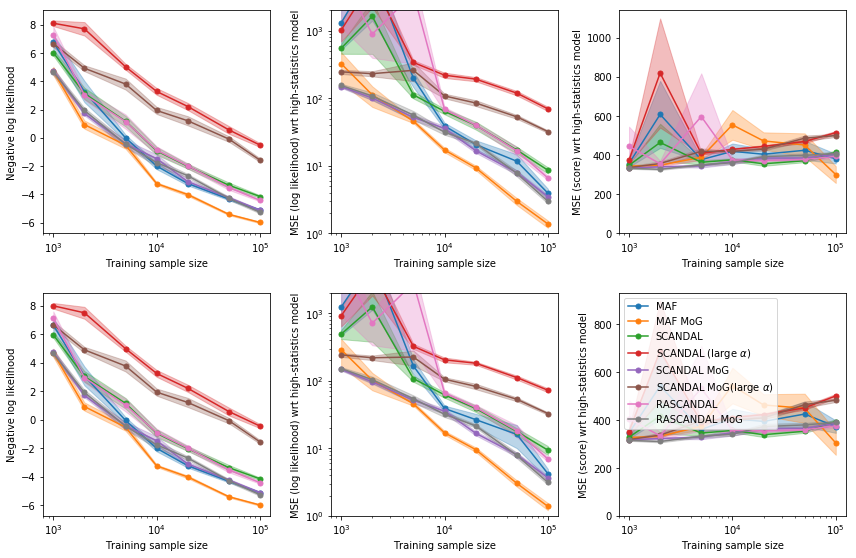

In [213]:
colors = ['C' + str(i) for i in range(10)]

fig = plt.figure(figsize=(12,8))



ax = plt.subplot(2,3,1)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        - expected_log_p_st_mean[m] - expected_log_p_st_uncertainty[m],
        - expected_log_p_st_mean[m] + expected_log_p_st_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        - expected_log_p_st_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
#plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('Negative log likelihood')
ax.set_xscale("log", nonposx='clip')
#plt.ylim(-20.,200.)



ax = plt.subplot(2,3,2)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        mse_st_mean[m] - mse_st_uncertainty[m],
        mse_st_mean[m] + mse_st_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        mse_st_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
#plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (log likelihood) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.ylim(1.,2000.)



ax = plt.subplot(2,3,3)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        score_mse_st_mean[m] - score_mse_st_uncertainty[m],
        score_mse_st_mean[m] + score_mse_st_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        score_mse_st_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
#plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (score) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.ylim(0.,None)



ax = plt.subplot(2,3,4)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        - expected_log_p_mean[m] - expected_log_p_uncertainty[m],
        - expected_log_p_mean[m] + expected_log_p_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        - expected_log_p_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
#plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('Negative log likelihood')
ax.set_xscale("log", nonposx='clip')
#plt.ylim(-20.,200.)



ax = plt.subplot(2,3,5)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        mse_mean[m] - mse_uncertainty[m],
        mse_mean[m] + mse_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        mse_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
#plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (log likelihood) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.ylim(1.,2000.)



ax = plt.subplot(2,3,6)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        score_mse_mean[m] - score_mse_uncertainty[m],
        score_mse_mean[m] + score_mse_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        score_mse_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (score) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.ylim(0.,None)
    
    

plt.tight_layout()
plt.show()
